In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
import yaml
import json
import torch

import gc
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from basin_volume import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
print(jax.__version__)

0.4.38


# Tokenizer

In [2]:

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-14m")

In [3]:
tokenizer.eos_token_id = 0
tokenizer.pad_token_id = 1

In [4]:
len(tokenizer.vocab)

50277

In [5]:
type(tokenizer)

transformers.models.gpt_neox.tokenization_gpt_neox_fast.GPTNeoXTokenizerFast

# Model

In [6]:

model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-14m").to("cuda")

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [7]:
# for name, p in model.named_parameters():
#     print(name, p.shape)
# print()

# sort by number of parameters and print
sorted_params = sorted(model.named_parameters(), key=lambda x: np.prod(x[1].shape))
# compute total number of parameters
total_params = sum(np.prod(p.shape) for name, p in sorted_params)
print(f"Total number of parameters: {total_params}")

# compute total embedding parameters
embedding_params = sum(np.prod(p.shape) for name, p in sorted_params if "embed" in name)
print(f"Total number of embedding parameters: {embedding_params}")
print(f"Total number of non-embedding parameters: {total_params - embedding_params}")

# for name, p in reversed(sorted_params):
#     print(f"{np.prod(p.shape) / total_params:.2%}", p.shape, name)

Total number of parameters: 14067712
Total number of embedding parameters: 12877824
Total number of non-embedding parameters: 1189888


In [8]:
trained_params_t = torch.nn.utils.parameters_to_vector(model.parameters()).detach()

In [9]:
trained_params_j = jax.dlpack.from_dlpack(trained_params_t)

In [10]:
print(summarize(trained_params_j))
print(summarize(trained_params_t))


{'type': <class 'jaxlib.xla_extension.ArrayImpl'>, 'size': 14067712, 'info': {'shape': (14067712,), 'dtype': dtype('float32'), 'device': CudaDevice(id=0)}}
{'type': <class 'torch.Tensor'>, 'size': 14067712, 'info': {'shape': torch.Size([14067712]), 'dtype': torch.float32, 'device': device(type='cuda', index=0)}}


# Dataset

In [11]:
with open("../data/val.jsonl", "r") as f:
    text_val = [json.loads(line)['text'] for line in f]

## Sampling

In [13]:
print(text_val[0])

Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests

image copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont

Catalonia's ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.

He said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.

Spain's Prime Minister Mariano Rajoy later appeared to reject the idea.

He said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.

He avoided naming Mr Puigdemont, adding that the winner of Thursday's election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.

The Citizens party is now the region's biggest party. although pro-independence par

In [23]:
# sample from model

input_ids = tokenizer(text_val[:2], return_tensors="pt", padding=True, truncation=True, max_length=512)['input_ids']
logits = model.generate(input_ids.to("cuda"), 
                        max_new_tokens=512, 
                        do_sample=True,
                        temperature=0.7,
                        top_k=50,
                        top_p=0.95,
                        )
print(logits.shape)
print(tokenizer.decode(logits[0], skip_special_tokens=True))
print(tokenizer.decode(logits[1], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([2, 1024])
Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests

image copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont

Catalonia's ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.

He said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.

Spain's Prime Minister Mariano Rajoy later appeared to reject the idea.

He said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.

He avoided naming Mr Puigdemont, adding that the winner of Thursday's election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.

The Citizens party is now the region's biggest party. althoug

## Padding scratch

In [145]:
n_seqs = 40
out = model(tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [ ]:
n_seqs = 40
out = model(tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [94]:
short_texts = [text_val[i] for i in indices+[0]]
out = model(tokenizer(short_texts, return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [95]:
out.logits.shape

torch.Size([41, 1024, 50304])

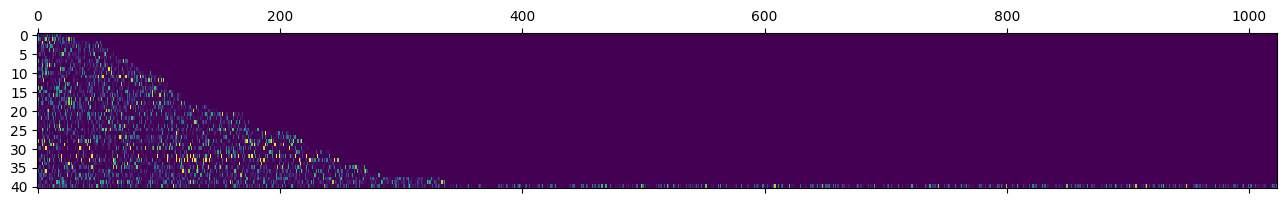

In [110]:
plt.matshow(tokenizer(short_texts, return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'].detach().numpy(), aspect='auto')

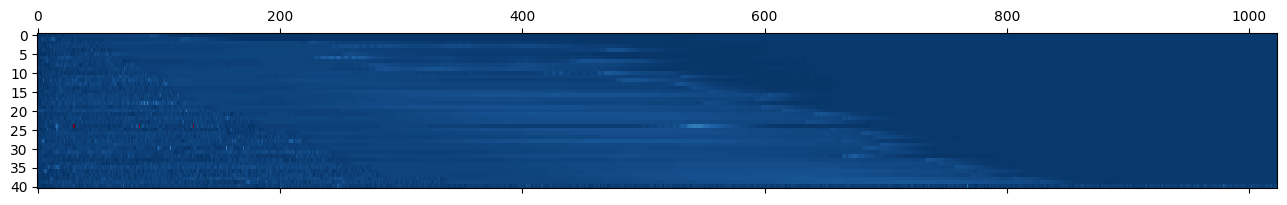

In [ ]:
plt.matshow(out.logits[:, :, 1].detach().numpy(), cmap='RdBu', aspect='auto')

In [156]:
lens[60]

715

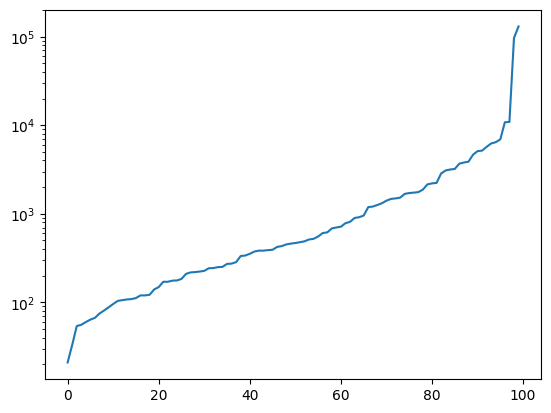

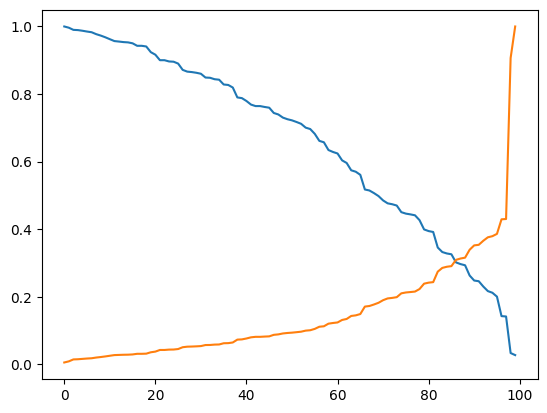

In [154]:
lens = sorted(map(lambda t: len(tokenizer(t)['input_ids']), text_val[:100]))
def frac_filled(lens, max_len):
    return sum(min(l, max_len) for l in lens) / (max_len * len(lens))
def frac_used(lens, max_len):
    return sum(min(l, max_len) for l in lens) / sum(lens)

plt.plot(lens)
plt.yscale('log')
plt.show()


plt.plot([frac_filled(lens, max_len) for max_len in lens])
plt.plot([frac_used(lens, max_len) for max_len in lens])
plt.show()

In [143]:
# get indices of shortest 40 sequences
indices = sorted(range(len(text_val[:100])), key=lambda i: len(tokenizer(text_val[i])['input_ids']))[:n_seqs]

In [144]:
summarize(out)

{'type': transformers.modeling_outputs.CausalLMOutputWithPast,
 'size': 2,
 'contents': [{'key': 'logits',
   'value': {'type': torch.Tensor,
    'size': 2111963136,
    'info': {'shape': torch.Size([41, 1024, 50304]), 'dtype': torch.float32}}},
  {'key': 'past_key_values',
   'value': {'type': tuple,
    'size': 6,
    'contents': [{'type': tuple,
      'size': 2,
      'contents': [{'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}},
       {'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}}]},
     {'type': tuple,
      'size': 2,
      'contents': [{'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}},
       {'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype

## Val subset

In [76]:
n_seqs = 30
X_val_t = tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'].to("cuda")
X_val_j = jax.dlpack.from_dlpack(X_val_t)

# Basins

In [16]:
# https://github.com/EleutherAI/pythia/blob/main/models/14M/pythia-14m.yml
with open("../data/pythia-14m.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
l2_reg = config['weight-decay']
# TODO: determine if this is the correct train size
train_size = config['train-iters'] * config['train_micro_batch_size_per_gpu']
sigma_epoch = 1/jnp.sqrt(l2_reg * train_size)

In [17]:
sigma_params = jnp.sqrt(jnp.mean(trained_params_j**2))

In [18]:
print(sigma_epoch)  # way too small!
print(sigma_params)

0.001478281
0.32929182


In [19]:
def apply_fn(params, x, *, debug=False):
    # assign params to model
    params_t = torch.from_dlpack(params)
    torch.nn.utils.vector_to_parameters(params_t, model.parameters())
    if debug:
        print(f"{x.shape=}")
    return jax.dlpack.from_dlpack(model(x).logits.detach())

In [31]:
type(tokenizer.pad_token_id)

int

In [67]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg, debug=False):
    def kl_fn(a, b):
        # [model_dim]
        params_q = a + b
        # x: [batch, seq_len] (input_ids)
        # [batch, seq_len, vocab_size]
        logits_q = apply_fn(params_q, x, debug=debug)
        # [batch, seq_len, vocab_size]
        logprobs_q = jax.nn.log_softmax(logits_q)
        if debug:
            print(f"{logprobs_q.shape=} {probs_p.shape=}")
        # [batch, seq_len]
        kl_all = optax.kl_divergence(logprobs_q, probs_p)
        mask = jax.dlpack.from_dlpack(x != tokenizer.pad_token_id)
        # scalar
        kl_term = jnp.mean(kl_all[mask])
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)

        del logits_q, logprobs_q, kl_all, mask
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg, debug=False):
    logits_p = apply_fn(params_p, x, debug=debug)
    if debug:
        print(f"{logits_p.shape=}")
    probs_p = jax.nn.softmax(logits_p)
    if debug:
        print(f"{probs_p.shape=}")
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg, debug=debug)

## Experiments

In [77]:
kl_fn = make_kl_fn_params(trained_params_j, apply_fn, X_val_t, l2_reg=0.)   

In [78]:
kl_fn(trained_params_j, 0.)

2025-01-10 03:57:56.644165: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.76GiB (rounded to 6181355520)requested by op 
2025-01-10 03:57:56.644402: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ************************************_____________*******************______*************____________*
E0110 03:57:56.644436  689687 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6181355520 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6181355520 bytes.

In [35]:
CUTOFF = 1e-2

RESULTS = {} # estimates, props, mults, deltas, logabsint

In [36]:
result_size = 100

RESULTS['naive'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  cutoff=CUTOFF,
                                                  tol=100., #0.1,
                                                  debug=False,
                                                  torch_model=True,
                                                 )

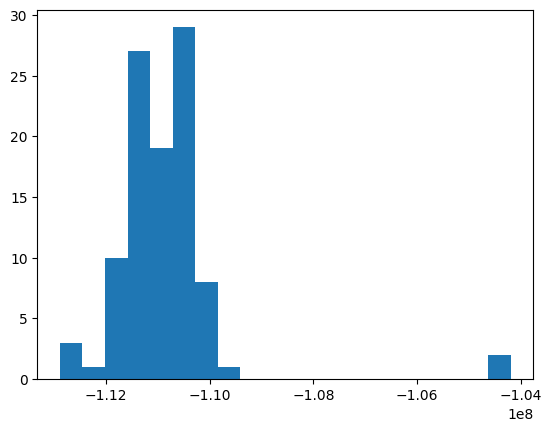

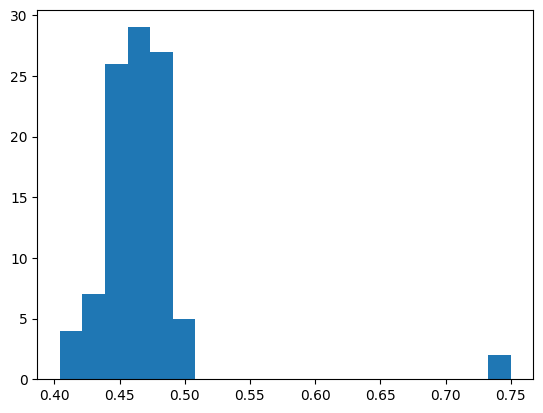

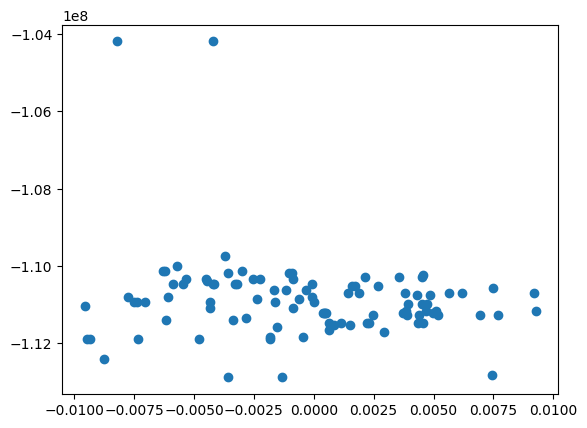

In [58]:
plt.hist(RESULTS['naive'][0], bins=20)
plt.show()

plt.hist(RESULTS['naive'][2], bins=20)
plt.show()

plt.scatter((RESULTS['naive'][3] - CUTOFF) / CUTOFF, RESULTS['naive'][0])
plt.show()


# Memory management

## Torch

In [ ]:
def get_tensor_memory_usage():
    # Force garbage collection first
    gc.collect()
    torch.cuda.empty_cache()
    
    # Get all tensors in memory)
    tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                tensors.append((obj.shape, obj.dtype, obj.element_size() * obj.nelement() / 1024**2))
        except:
            pass
    
    # Sort by memory usage (MB)
    return sorted(tensors, key=lambda x: x[2], reverse=True)

In [ ]:

# Print top 10 tensors by memory usage
for shape, dtype, size_mb in get_tensor_memory_usage()[:30]:
    print(f"Shape: {shape}, Dtype: {dtype}, Size: {size_mb:.2f} MB")

Shape: torch.Size([100, 1024, 50304]), Dtype: torch.float32, Size: 19650.00 MB
Shape: torch.Size([14067712]), Dtype: torch.float32, Size: 53.66 MB
Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([100, 1024]), Dtype: torch.int64, Size: 0.78 MB
Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.Size([128, 512]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.S

/opt/conda/envs/jax311/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
# total memory usage by Torch
print(f"Total memory usage by Torch: {sum(size_mb for _, _, size_mb in get_tensor_memory_usage())} MB")

Total memory usage by Torch: 19782.109504699707 MB


### Torch w/ Python

In [ ]:
def get_tensor_memory_usage():
    # Force garbage collection first
   (10, 1024, 50304)n gc.get_referrers(obj):
                    if isinstance(referrer, dict):
                        # If it's in a dictionary (like globals() or locals()),
                        # find variable names pointing to this tensor
                        for var_name, var_val in referrer.items():
                            if var_val is obj:
                                referrers.append(var_name)
                    
                tensor_info.append({
                    'shape': obj.shape,
                    'dtype': obj.dtype,
                    'size_mb': obj.element_size() * obj.nelement() / 1024**2,
                    'referrers': referrers
                })
        except:
            pass
    
    # Sort by memory usage (MB)
    return sorted(tensor_info, key=lambda x: x['size_mb'], reverse=True)

# Print top tensors by memory usage with their referrers
for info in get_tensor_memory_usage()[:30]:
    print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
    if info['referrers']:
        print(f"Referenced by: {info['referrers']}")
    print()

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


Shape: torch.Size([14067712]), Dtype: torch.float32, Size: 53.66 MB
Referenced by: ['trained_params_t']

Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Referenced by: ['weight']

Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Referenced by: ['weight']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Referenced by: ['weight']

Shape: torch.Size([128, 5

## JAX

In [79]:
def get_jax_memory_usage():
    # Force garbage collection
    gc.collect()
    
    # Get live arrays from JAX
    live_arrays = jax.live_arrays()
    
    # Calculate size and sort by memory usage
    array_sizes = []
    for arr in live_arrays:
        try:
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)  # Convert to MB
            array_sizes.append((shape, dtype, size_mb))
        except:
            pass
    
    # Sort by size
    array_sizes.sort(key=lambda x: x[2], reverse=True)
    
    # Print top arrays
    print("\nLargest JAX Arrays:")
    for shape, dtype, size_mb in array_sizes[:30]:
        print(f"Shape: {shape}, Dtype: {dtype}, Size: {size_mb:.2f} MB")
    
    total_mb = sum(size for _, _, size in array_sizes)
    print(f"\nTotal JAX Memory Usage: {total_mb:.2f} MB")

# Get current memory usage
get_jax_memory_usage()


Largest JAX Arrays:
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB
Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB
Shape: (30, 1024, 50304), Dtype: bool, Size: 1473.75 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (30, 1024), Dtype: int32, Size: 0.12 MB
Shape: (10, 1024), Dtype: int32, Size: 0.04 MB
Shape: (10, 1024), Dtype: int32, Size: 0.04 MB
Shape: (10, 1024), D

In [91]:
def get_jax_memory_usage():
    # Force garbage collection
    gc.collect()
    
    # Get live arrays from JAX
    live_arrays = jax.live_arrays()
    
    # Calculate size and track references
    array_info = []
    for arr in live_arrays:
        try:
            # Find all referrers to this array
            referrers = []
            for referrer in gc.get_referrers(arr):
                if isinstance(referrer, dict):
                    # If it's in a dictionary (like globals() or locals()),
                    # find variable names pointing to this array
                    for var_name, var_val in referrer.items():
                        if var_val is arr:
                            referrers.append(var_name)
            
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)  # Convert to MB
            array_info.append({
                'shape': shape,
                'dtype': dtype,
                'size_mb': size_mb,
                'referrers': referrers
            })
        except:
            pass
    
    # Sort by size
    array_info.sort(key=lambda x: x['size_mb'], reverse=True)
    
    # Print top arrays
    print("\nLargest JAX Arrays:")
    for info in array_info[:30]:
        print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
        if info['referrers']:
            print(f"Referenced by: {info['referrers']}")
        print()
    
    total_mb = sum(info['size_mb'] for info in array_info)
    print(f"\nTotal JAX Memory Usage: {total_mb:.2f} MB")

In [101]:
def get_jax_memory_usage():
    gc.collect()
    live_arrays = jax.live_arrays()
    
    array_info = []
    for arr in live_arrays:
        try:
            referrers = []
            for referrer in gc.get_referrers(arr):
                if isinstance(referrer, dict):
                    var_names = [name for name, val in referrer.items() if val is arr]
                    if var_names:
                        dict_referrers = gc.get_referrers(referrer)
                        for r in dict_referrers:
                            if isinstance(r, types.FrameType):
                                # Get frame info
                                frame_info = {
                                    'function': r.f_code.co_name,
                                    'filename': r.f_code.co_filename,
                                    'lineno': r.f_lineno
                                }
                                referrers.append({
                                    'names': var_names,
                                    'dict_type': str(type(referrer)),
                                    'frame': frame_info
                                })
            
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)
            array_info.append({
                'shape': shape,
                'dtype': dtype,
                'size_mb': size_mb,
                'referrers': referrers
            })
        except:
            pass
    
    array_info.sort(key=lambda x: x['size_mb'], reverse=True)
    
    print("\nLargest JAX Arrays:")
    for info in array_info[:30]:
        print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
        if info['referrers']:
            for ref in info['referrers']:
                print(f"Referenced as: {ref['names']}")
                if 'frame' in ref:
                    print(f"In function: {ref['frame']['function']}")
                    print(f"File: {ref['frame']['filename']}:{ref['frame']['lineno']}")
        print()

In [97]:
str(type([]))

"<class 'list'>"

In [102]:

# Get current memory usage
get_jax_memory_usage()


Largest JAX Arrays:
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB

Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB

Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (10, 1024), Dtype: int32, Size: 0.04 MB

Shape: (10, 1024), Dtype: int32, Size: 0.04 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32

In [81]:
def clear_memory():
    # Clear PyTorch cache
    gc.collect()
    torch.cuda.empty_cache()
    
    # Clear JAX cache
    jax.clear_caches()
    
    # Additional garbage collection
    gc.collect()

# Usage
clear_memory()